In [ ]:
!pip install stylecloud
!pip install --upgrade vaderSentiment
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#pip install -U scikit-learn
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import csv
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import sys
pd.set_option('display.max_columns', 50)

# Import Plotly Packages
import plotly 
import plotly.offline as py
import plotly.graph_objs as go
import plotly.express as px
from plotly.offline import init_notebook_mode, plot, iplot


## sklearn Packages
import sklearn
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

# Import NLP Packages
import re
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from wordcloud import WordCloud
import stylecloud

# NLTK Stop words
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
from pprint import pprint
import matplotlib.colors as mcolors


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


**Read in CSV**# Read in CSV

In [ ]:
business_final = pd.read_csv("/content/gdrive/MyDrive/restaurant recomendation system/business_final.csv")
print(business_final.shape)

(3527, 11)


In [ ]:
review_final = pd.read_csv("/content/gdrive/MyDrive/restaurant recomendation system/review_final.csv")
print(review_final.shape)

(78410, 9)


EDA on PA Business Data

In [ ]:
px.set_mapbox_access_token("pk.eyJ1IjoiY3QzMDU3IiwiYSI6ImNsZmFpN2diMDA1dGQzdG1lNXh4bzYwdmEifQ.Fu4HqAVGPG9XaGVDwEd2pg")
fig = px.scatter_mapbox(business_final, lat="latitude", lon="longitude", color="stars", size='review_count', hover_name='name', text='name',
                   size_max=15, zoom=10, width=1000, height=800)
#fig.update_layout(mapbox_style="dark")
fig.show()

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Nightlife'),
  Text(1, 0, 'Bars'),
  Text(2, 0, 'Sandwiches'),
  Text(3, 0, 'Pizza'),
  Text(4, 0, 'American (Traditional)')])

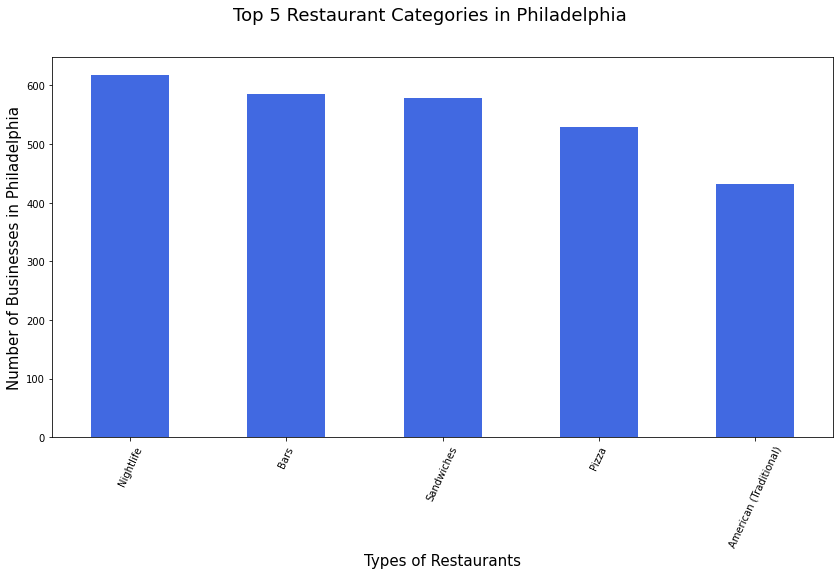

In [ ]:
restaurant_categories = business_final.assign(categories = business_final.categories.str.split(', ')).explode('categories')
top25_categories = restaurant_categories.categories.value_counts().head(7)

fig, ax = plt.subplots(figsize=(14, 7))
fig.suptitle('Top 5 Restaurant Categories in Philadelphia', fontsize=18)

# Excluding the top 2 most generic categories: Restaurants & Food

top25_categories[2:].plot(kind = 'bar', color = 'royalblue')

plt.ylabel('Number of Businesses in Philadelphia', fontsize=15)
plt.xlabel('Types of Restaurants', fontsize=15)
plt.xticks(rotation=65)

In [ ]:
len(set(restaurant_categories['categories']))

363

In [ ]:
Philadelphia_nightlife = business_final[business_final['categories'].str.contains("Nightlife")]
print(Philadelphia_nightlife.shape)
Philadelphia_nightlife.head() # 618 Nightlife type of Restaurants

(618, 11)


,index,business_id,name,city,state,stars,review_count,categories,latitude,longitude,postal_code
14,443,7mpYTDb24SywNMRn3yeakQ,The Twisted Tail,Philadelphia,PA,4.0,604,"Event Planning & Services, Whiskey Bars, Ameri...",39.941877,-75.145199,19147
23,865,MYoRNLb5chwjQe3c_k37Gg,Sean Thorntons Public House,Philadelphia,PA,3.5,6,"Food, Nightlife, Restaurants, Irish Pub, Bars,...",39.988107,-75.105553,19134
27,1091,BxR5hjyBnJZrm_nnaCtGQw,The Lunar Inn,Philadelphia,PA,4.5,29,"Bars, Food, Restaurants, Beer, Wine & Spirits,...",39.982293,-75.103160,19134
28,1106,NQSnr4RPUScss607oxOaqw,Chase's Hop Shop,Philadelphia,PA,4.5,116,"Chicken Wings, Nightlife, Bars, Delis, Food, B...",40.060386,-75.084590,19111
37,1437,68ThEdiK0eWCEgGEmV9Tng,Southgate,Philadelphia,PA,4.0,323,"Breakfast & Brunch, American (Traditional), Ko...",39.945569,-75.171790,19146


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [ ]:
Philadelphia_nightlife.value_counts()

index   business_id             name                      city          state  stars  review_count  categories                                                                                                                                                                      latitude   longitude   postal_code
443     7mpYTDb24SywNMRn3yeakQ  The Twisted Tail          Philadelphia  PA     4.0    604           Event Planning & Services, Whiskey Bars, American (New), American (Traditional), Venues & Event Spaces, Bars, Nightlife, Restaurants                                            39.941877  -75.145199  19147          1
104723  VoOlwCavQQ_A5My7TC7t2w  Mix Bar and Grill         Philadelphia  PA     3.0    29            Bars, Restaurants, Nightlife, Pizza, American (New)                                                                                                                             39.952444  -75.175757  19103          1
103351  n2976VTltvlSwENZxYJoNQ  Reedy's Tavern           

Text(0, 0.5, 'Number of Restaurants')

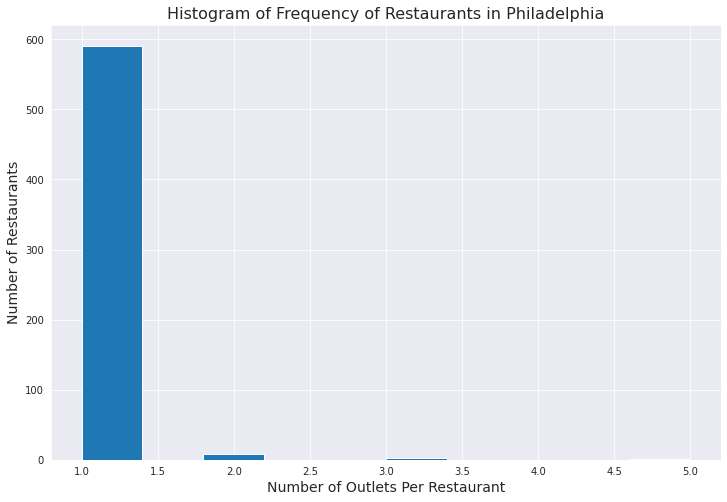

In [ ]:
sns.set_style("darkgrid")
plt.figure(figsize=(12,8))
plt.hist(Philadelphia_nightlife.name.value_counts(), bins=10)
plt.title('Histogram of Frequency of Restaurants in Philadelphia', fontsize=16)
plt.xlabel('Number of Outlets Per Restaurant', fontsize=14)
plt.ylabel('Number of Restaurants', fontsize=14)

In [ ]:
Philadelphia_Chinese = business_final[business_final['categories'].str.contains("Chinese")]
print(Philadelphia_Chinese.shape)
Philadelphia_Chinese.head() # 300 Chinese type of Restaurants

(300, 11)


,index,business_id,name,city,state,stars,review_count,categories,latitude,longitude,postal_code
5,130,3BJxm-HnvzdwD1zjmSbmyQ,Golden Chopstick Chinese Restaurant,Philadelphia,PA,3.0,137,"Restaurants, Chinese",39.963078,-75.168027,19130
47,1936,V5KiEoH4E86GA2S3RQkf1g,Spice Grill,Philadelphia,PA,3.5,12,"Restaurants, Chinese, Asian Fusion",39.986272,-75.094699,19134
48,1937,MMRRS6YhVRx_iN5-JhMRYg,Han Dynasty,Philadelphia,PA,4.0,783,"Restaurants, Chinese, Szechuan",39.956711,-75.197103,19104
55,2270,n6dw_zxL_4cVO6EP_m0joQ,Dragon House,Philadelphia,PA,4.0,5,"Restaurants, Chinese",39.950359,-75.161584,19107
57,2331,Zk_GdMMPgEfKUECCxAxvwQ,Pho Nam Giang,Philadelphia,PA,4.5,23,"Chinese, Restaurants, Vietnamese, Asian Fusion",40.086078,-74.964808,19154


In [ ]:
Philadelphia_Chinese.name.value_counts()

China House             7
Panda Express           4
China King              3
Han Dynasty             3
New China               3
                       ..
Good Flavor             1
King Food               1
Kim's Oriental Food     1
King Food Restaurant    1
Bo Sing                 1
Name: name, Length: 275, dtype: int64

In [ ]:
Philadelphia_handynasty = Philadelphia_Chinese[Philadelphia_Chinese['name'].str.contains("Han Dynasty")]
Philadelphia_handynasty

,index,business_id,name,city,state,stars,review_count,categories,latitude,longitude,postal_code
48,1937,MMRRS6YhVRx_iN5-JhMRYg,Han Dynasty,Philadelphia,PA,4.0,783,"Restaurants, Chinese, Szechuan",39.956711,-75.197103,19104
535,22091,bffLbfi1IEAff5C2IHJvFA,Han Dynasty,Philadelphia,PA,3.5,417,"Chinese, Restaurants",40.025374,-75.223863,19127
3270,139771,qISf5ojuYbD9h71NumGUQA,Han Dynasty,Philadelphia,PA,4.0,1474,"Beer, Wine & Spirits, Chinese, Restaurants, Fo...",39.948526,-75.143728,19106


In [ ]:
px.set_mapbox_access_token("pk.eyJ1IjoiY3QzMDU3IiwiYSI6ImNsZmFpN2diMDA1dGQzdG1lNXh4bzYwdmEifQ.Fu4HqAVGPG9XaGVDwEd2pg")
fig = px.scatter_mapbox(Philadelphia_handynasty, lat="latitude", lon="longitude", color="stars", size='review_count', hover_name='name', text='name',
                   size_max=15, zoom=10, width=1000, height=800)
#fig.update_layout(mapbox_style="dark")
fig.show()

In [ ]:
Philadelphia_review_count = business_final.sort_values(by = 'review_count', ascending = False)
Philadelphia_review_count

,index,business_id,name,city,state,stars,review_count,categories,latitude,longitude,postal_code
3335,143157,ytynqOUb3hjKeJfRj5Tshw,Reading Terminal Market,Philadelphia,PA,4.5,5721,"Candy Stores, Shopping, Department Stores, Fas...",39.953341,-75.158855,19107
2682,113983,PP3BBaVxZLcJU54uP_wL6Q,Pat's King of Steaks,Philadelphia,PA,3.0,4250,"Italian, American (Traditional), Sandwiches, F...",39.933201,-75.159266,19147
1368,57332,IkY2ticzHEn4QFn8hQLSWg,Geno's Steaks,Philadelphia,PA,2.5,3401,"Sandwiches, Cheesesteaks, Steakhouses, Restaur...",39.933837,-75.158814,19147
3071,131670,9PZxjhTIU7OgPIzuGi89Ew,El Vez,Philadelphia,PA,4.0,3187,"Lounges, Bars, Nightlife, Breakfast & Brunch, ...",39.949702,-75.161770,19107
769,31165,ctHjyadbDQAtUFfkcAFEHw,Zahav,Philadelphia,PA,4.5,3065,"Nightlife, Bars, Food, Ethnic Food, Middle Eas...",39.946261,-75.145135,19106
...,...,...,...,...,...,...,...,...,...,...,...
1409,59123,Pk8wDjFerE25edYymxRDPg,Stenton Pizza,Philadelphia,PA,2.0,5,"Restaurants, Pizza",40.059483,-75.164742,19138
2879,122036,usp2gEf_Y2Uf4bxIxET1_g,Geno's Steaks,Philadelphia,PA,1.0,5,"Restaurants, Cheesesteaks",39.904389,-75.168915,19148
2614,111509,E_EJIx6Qw74r6clNeVpldQ,Chester Family Pizza,Philadelphia,PA,3.0,5,"Restaurants, Pizza",39.938504,-75.224364,19143
1900,80598,DIz7ET7IDNsfvYp7p5RZyA,The Stand,Philadelphia,PA,3.5,5,"Chicken Wings, Steakhouses, American (New), Re...",40.013776,-75.157901,19140


In [ ]:
Philadelphia_review_count.review_count.value_counts()


5       125
6       108
7        91
8        91
9        85
       ... 
469       1
466       1
465       1
220       1
5721      1
Name: review_count, Length: 609, dtype: int64

<ipython-input-19-20d3114facff>:3: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




Text(0, 0.5, 'Number of Restaurants')

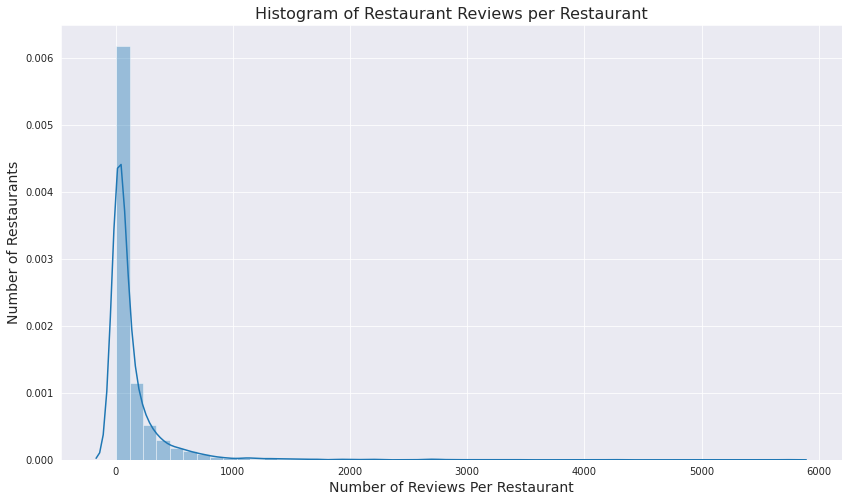

In [ ]:
sns.set_style("darkgrid")
plt.figure(figsize=(14,8))
sns.distplot(Philadelphia_review_count['review_count'])
plt.title('Histogram of Restaurant Reviews per Restaurant', fontsize = 16)
plt.xlabel('Number of Reviews Per Restaurant', fontsize=14)
plt.ylabel('Number of Restaurants', fontsize=14)

EDA on Reviews Data

In [ ]:
print(review_final.shape)
review_final.head(3)

(78410, 9)


,business_id,review_id,user_id,stars,useful,funny,cool,text,date
0,cPDX2Y4H0fks-Qj5tfBduA,YP4dpdLt7iomIJGIweKTjg,K97i0e7MaxYfvCCwPFMjuw,3,0,0,0,This is solely for the cupcakes. So I retuned ...,2011-07-24 17:44:29
1,cPDX2Y4H0fks-Qj5tfBduA,Dsz8hsLQNDJntT45PxG4HQ,ubPlKiHayyv2puouC1faMQ,5,0,0,0,An enchantingly wonderful happy place! Tartes...,2016-03-04 23:56:35
2,cPDX2Y4H0fks-Qj5tfBduA,d6HqIoLPBkBGE_eME6P3aA,0ENLV8uFNuZEehc48HwYzw,5,1,0,1,"Perfect coconut, key lime and apple crumb tart...",2012-04-14 19:32:15


In [ ]:
# Overall Distribution of Restaurant Ratings from Yelp Users

data = review_final['stars'].value_counts().sort_index(ascending=False)

trace = go.Bar(x = data.index,
               text = ['{:.1f} %'.format(val) for val in (data.values / review_final.shape[0] * 100)],
               textposition = 'auto',
               textfont = dict(color = '#000000'),
               y = data.values
               )

# Create layout

layout = dict(title = 'Distribution Of {} Restaurant Ratings from Yelp Users'.format(review_final.shape[0]),
              xaxis = dict(title = 'Count'),
              yaxis = dict(title = 'Rating / Stars'))

# Create distribution plot

fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

Sentiment Analysis

In [ ]:

review_final['text'].head()

0    This is solely for the cupcakes. So I retuned ...
1    An enchantingly wonderful  happy place! Tartes...
2    Perfect coconut, key lime and apple crumb tart...
3    The tarts here are fantastic.  I love the crem...
4    Third trip to Tartes, third time I've been sat...
Name: text, dtype: object

In [ ]:
one_star_reviews = review_final[review_final['stars'] == 1.0]
two_star_reviews = review_final[review_final['stars'] == 2.0]
negative_reviews = [one_star_reviews, two_star_reviews]
negative_reviews = pd.concat(negative_reviews)
print(negative_reviews.shape)
negative_reviews.sample(5)

(13044, 9)


,business_id,review_id,user_id,stars,useful,funny,cool,text,date
42496,ExJjmQZ6M01JDbHFQ8CbzA,7KlCtr1dD84-ZrCnRptuFw,26XyS1oSfAHrnm-kAbAyNg,1,1,0,0,Absolutely atrocious experience with this plac...,2018-07-07 04:14:09
56182,FJl6LCHbqiM9mvSwDjFAjw,VMmIpD5Uj6gnYu8O0ZgwbQ,CtDcNDYliPWBOYHkCUGNGw,2,0,0,0,I feel so disappointed about Kim. Cuz I have b...,2019-04-28 23:07:19
48270,d28lZlSps97FHhXZazJ8zA,0VdlKdMs4ZRyKgWoNvXglQ,XiXQiVpCXSOfr0YVZP1ulA,2,0,0,0,Second time in a row coming here and they have...,2014-11-29 19:41:43
75131,hc7I_QpCszT3mlIP9uW19w,njmuxFo2GqIZSXK5setiFQ,O7LGGq7pKK6aO-RwTdzS2w,2,1,0,1,Nice way to totally blow your Yelp reviews. Of...,2017-02-12 20:55:59
60038,kxKai8GE5oDMPevV7oxvbA,V8qzHqSkKNRixLSHmUnK-w,A-FdUqPuZgtbTvdZLFRzfg,1,0,0,0,Wow how unimpressive. The food was ok but the ...,2015-04-26 00:36:32


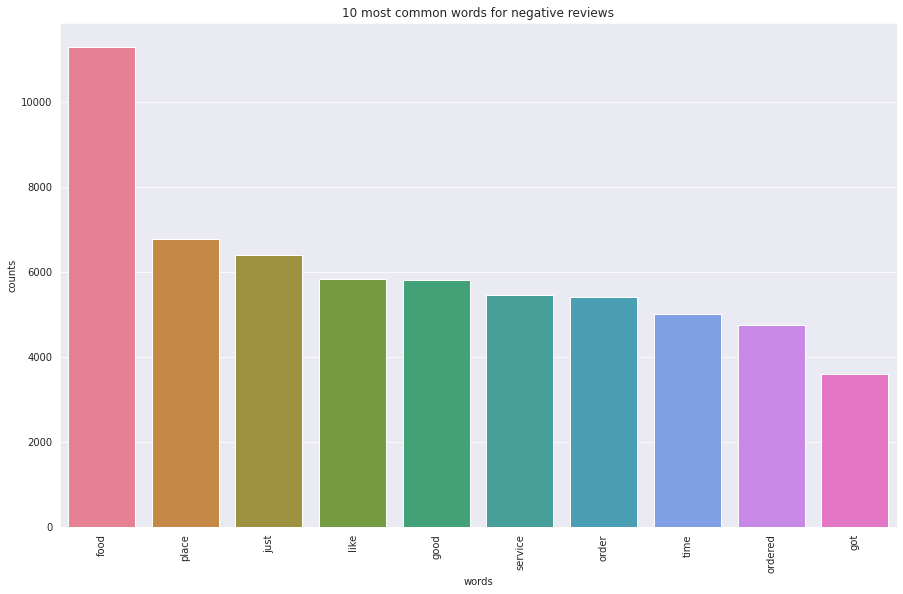

In [ ]:
def plot_10_most_common_words(count_data, count_vectorizer):
    words = count_vectorizer.get_feature_names_out()
    #scikit-learn2.0 https://stackoverflow.com/questions/70640923/countvectorizer-object-has-no-attribute-get-feature-names-out
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words for negative reviews')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x=x_pos, y=counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
    
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(negative_reviews['text'])

# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

In [ ]:

cvec = CountVectorizer(min_df = 2, stop_words= stop_words, max_features = 1000)
cvec.fit(negative_reviews['text'])
# Transforming using our fitted cvec and converting the result to a DataFrame

negative_words = pd.DataFrame(cvec.transform(negative_reviews['text']).todense(),
                       columns=cvec.get_feature_names_out())

negative_top = negative_words.sum(axis = 0).sort_values(ascending = False).head(150)
negative_pd = pd.DataFrame(data=negative_top)
negative_top = negative_words[negative_pd.index]
negative_top.drop(columns=['food','like', 'restaurant', 'place', 'got'], inplace = True)
negative_top.head()

<ipython-input-25-2d962244ac0f>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,service,order,one,time,us,ordered,back,never,came,really,minutes,asked,said,table,told,went,people,chicken,first,better,great,two,cheese,experience,bad,...,horrible,let,stars,everything,decided,always,thought,looked,beer,seated,review,friends,location,worth,served,cheesesteak,soup,actually,walked,later,eating,person,definitely,rice,enough
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,2,1,0,0,1,0,2,0,0,0,0,0,0,0,2,1,0,1,0,0,2,...,0,0,1,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,0,0,0,0,0,0,0


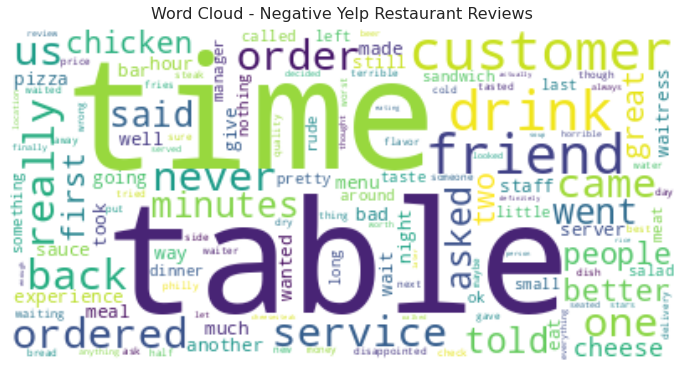

In [ ]:
wordcloud_low = WordCloud(background_color="white").generate(' '.join(negative_top))
plt.figure(figsize = (12,10))
plt.imshow(wordcloud_low, interpolation='bilinear')
plt.title('Word Cloud - Negative Yelp Restaurant Reviews', fontsize=16, y=1.01)
plt.axis("off");

In [ ]:
negative_reviews['counter'] = 1
negative_reviews.head()

,business_id,review_id,user_id,stars,useful,funny,cool,text,date,counter
12,cPDX2Y4H0fks-Qj5tfBduA,kquSWOqtxPMxknbh_l2tRA,C9Vp84eyIvKzUvETiG7Q1w,1,0,1,0,Extremely rude lady tending customers. Hides b...,2018-04-14 18:58:37,1
28,cPDX2Y4H0fks-Qj5tfBduA,a6TI_Pj501OQdDUUhoz53A,g04eScEKgZihgLqeuhm1cg,1,1,0,0,Customer service is seriously lacking from the...,2018-04-04 22:15:12,1
49,cPDX2Y4H0fks-Qj5tfBduA,JSKfADEZncWIBATfqVdk9A,De9L1xCtbO-HL33URZW62A,1,1,0,0,"Wow, what a sad experience and far below any b...",2019-10-11 00:11:03,1
61,cPDX2Y4H0fks-Qj5tfBduA,_6u1ocnFFUlUI2O8nQpBUw,iJE3RnVcfHM3jsM4I6WFCw,1,2,4,2,Stopped here for some cupcakes. They were out ...,2015-11-08 14:25:18,1
82,9c7MUiE6VI8NesjPdj5FkA,AK-JiU6tjGuUc0Z7szrezA,tOvAcDPjOQLnFkArPVSSTA,1,1,3,0,I do not normally give lower than two stars un...,2018-06-07 02:27:00,1


In [ ]:
negative_reviews.groupby('business_id')['counter'].sum().sort_values(ascending = False)


business_id
RQAF6a0akMiot5lZZnMNNw    213
AmI3LIUNwsi4023hOVGu3w    190
-mIlmp5l4hKlp1tvHRdvTg    180
T9C1od-JorSPXwXgzSqM9Q    163
SCjUeZfjafJ88fWWQjRh2w    162
                         ... 
lh3QYUmMsx1gSnH2dYwJSg      1
Nsh4KiDEu5xWhPjJftSESA      1
l02jjfbmaLhHKCX39FOrBg      1
OcWuxEqm_5gTz7oPSHB6Jw      1
VOBvxu8SzLGSun8o5OFhjA      1
Name: counter, Length: 643, dtype: int64

In [ ]:
# Restaurant with most negative reviews

worst_restaurant = business_final[business_final['business_id'] == 'RQAF6a0akMiot5lZZnMNNw']
worst_restaurant

,index,business_id,name,city,state,stars,review_count,categories,latitude,longitude,postal_code
910,36746,RQAF6a0akMiot5lZZnMNNw,Dalessandro’s Steaks & Hoagies,Philadelphia,PA,4.0,2686,"Sandwiches, Delis, Restaurants, Cheesesteaks",40.029494,-75.205971,19128


In [ ]:
# Filtering Reviews from the Worst Restaurant

worst_restaurant_reviews = negative_reviews[negative_reviews['business_id'] == 'RQAF6a0akMiot5lZZnMNNw']
worst_restaurant_reviews

,business_id,review_id,user_id,stars,useful,funny,cool,text,date,counter
56291,RQAF6a0akMiot5lZZnMNNw,LSPYWh_Q7OvpVCcqoLIHqg,khNsRUYf7Qr2NtsLbq_bHA,1,0,0,0,Sorry I don't see it here. It was good years a...,2013-01-28 21:48:12,1
56298,RQAF6a0akMiot5lZZnMNNw,82To1scSG4KSNQHq2juR9A,gO5m437h6XOuUFxa2VuBcA,1,0,1,0,Hard to find if you're not familiar with the a...,2011-07-01 12:40:09,1
56304,RQAF6a0akMiot5lZZnMNNw,XEwClCORlp5eZ_ulaYmZYA,l9JbR--FottHxN93WagApA,1,0,0,0,don't see what all the fuss is about. ate ther...,2017-10-25 18:10:06,1
56357,RQAF6a0akMiot5lZZnMNNw,MVr3bj-JJBlnpTmw-ibITg,gipg80Wjz1eNpw_O7viztA,1,3,0,0,Why do people like this place?? I pass it almo...,2016-02-13 04:08:18,1
56384,RQAF6a0akMiot5lZZnMNNw,mCy8wzDevVvdu9WanCIcqw,d3IwmrTq8eCw8g8tVZqbzg,1,0,0,0,This place has been sold so many times since i...,2016-12-21 21:06:22,1
...,...,...,...,...,...,...,...,...,...,...
58345,RQAF6a0akMiot5lZZnMNNw,j94cVkXLN5NB4Vx9cnT-4Q,_t3svYhkCV3i76whxb4WYA,2,0,0,0,Not bad if you're looking for spaghetti on a h...,2021-10-11 17:10:42,1
58357,RQAF6a0akMiot5lZZnMNNw,Sf13LGynu7nc_J9DeeuTQQ,gECTGhoToWi4PPxhSlJ40g,2,2,1,2,Their new system for customer service sucks an...,2021-01-31 00:24:00,1
58399,RQAF6a0akMiot5lZZnMNNw,-GlE32OhgBZUe502YgWMwQ,x2ygWyyDbSab60vFdUp4fw,2,1,1,0,It's a bit sad that I've had a better cheesest...,2021-09-28 14:52:48,1
58411,RQAF6a0akMiot5lZZnMNNw,ZCHZpjmA0CNrKKPNxG8QSA,BTHXLOCKyo1z8ZrWq8-9_g,2,3,2,2,"Yup, that's all.. two stars.. and it's really ...",2016-09-26 16:34:40,1


In [ ]:
# Let's use the stop_words argument to remove words like "and, the, a"

cvec = CountVectorizer(min_df = 2, stop_words= stop_words, max_features = 1000)
cvec.fit(worst_restaurant_reviews['text'])

# Transforming using our fitted cvec and converting the result to a DataFrame

negative_words = pd.DataFrame(cvec.transform(worst_restaurant_reviews['text']).todense(),
                       columns=cvec.get_feature_names_out())

negative_top = negative_words.sum(axis = 0).sort_values(ascending = False).head(300)
negative_pd = pd.DataFrame(data=negative_top)
negative_top = negative_words[negative_pd.index]
negative_top.drop(columns=['food','like', 'restaurant', 'place', 'better', 'great', 'pork', 'chicken','really', 'much','one', 'us', 'got', 'came','steak','cheese','steaks','cheesesteak'], inplace = True)
negative_top.head()

<ipython-input-31-dec3210b7377>:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,meat,order,sandwich,philly,people,service,time,wait,way,cheesesteaks,onions,back,best,dalessandro,worth,rude,minutes,never,ordered,flavor,street,taste,going,dry,first,...,times,edible,thing,home,condiments,seasoning,amount,onion,seriously,sub,paid,serve,stopped,stop,anyway,decent,sharp,guy,needed,point,making,clearly,stand,getting,worse
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,5,0,0,0,0,3,0,0,0,1,0,0,0,0,0,0,2,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
column_list = list(negative_top)
negative_words = negative_top[column_list].sum(axis=0)
negative_words = negative_words.to_frame(name = 'sum').reset_index()
negative_words.set_index('index',inplace = True)
negative_words.to_csv("/content/gdrive/MyDrive/restaurant recomendation system/negative_words.csv")

In [ ]:

negative_words.shape

(282, 1)

In [ ]:

thumbs_down = stylecloud.gen_stylecloud(file_path="/content/gdrive/MyDrive/restaurant recomendation system/negative_words.csv", 
                                        icon_name = "fas fa-thumbs-down",
                                        size = 550,
                                        palette="colorbrewer.sequential.RdPu_3", 
                                        background_color="white",
                                        output_name = '/content/gdrive/MyDrive/restaurant recomendation system/Negative_Reviews.png')

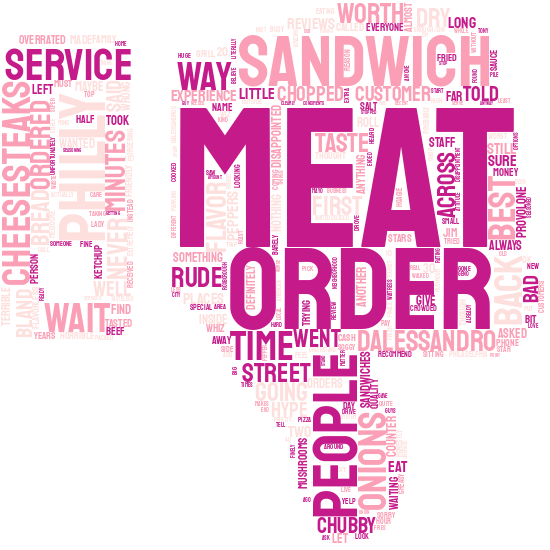

In [ ]:
from IPython.display import Image
Image(filename='/content/gdrive/MyDrive/restaurant recomendation system/Negative_Reviews.png')

Positive Reviews

In [ ]:
# Filtering for positive reviews (five star)

positive_reviews = review_final[review_final['stars'] == 5.0]
print(positive_reviews.shape)
positive_reviews.sample(5)

(34639, 9)


,business_id,review_id,user_id,stars,useful,funny,cool,text,date
26377,mf0OyZ6DX2iKUFIV9TqFRQ,8TK157TnizZ6ZAP0Xu1JPg,qnoT0ceBFvLyv7OEks64BQ,5,0,0,0,Moriarty's on 11th and Walnut was a great expe...,2014-03-10 02:06:59
12833,j-qtdD55OLfSqfsWuQTDJg,YtS2IhNWWDEXPmOFy7v29A,lPG_i3iaDu9HLvQ4xKLAeA,5,1,0,0,Parc is one of Philadelphia's staples located ...,2019-05-06 21:49:13
23717,BX3LLonrLLLfVX-tNrE7yA,ODZyKryhD5XMt8Va9WKOgg,4y5ZrSMHFw83OFV7hQBndQ,5,0,0,0,What a great find! This is very good Vietnames...,2018-08-03 14:15:01
14040,iUZEGx29miZObLd6_lt7Vg,RgvHy17tAjvr6MPzBDY5sQ,lZKoeHvAfBa7R168hwwS6Q,5,0,0,0,Pretty busy but totally worth the wait! The hu...,2018-03-18 17:56:17
56932,RQAF6a0akMiot5lZZnMNNw,zB7f5l-Zb6vaGq7huFUwSw,vyQfrtDRhnGpC6WoVzS-HQ,5,0,0,0,The most underrated cheesesteak place. I bring...,2018-09-08 14:30:07


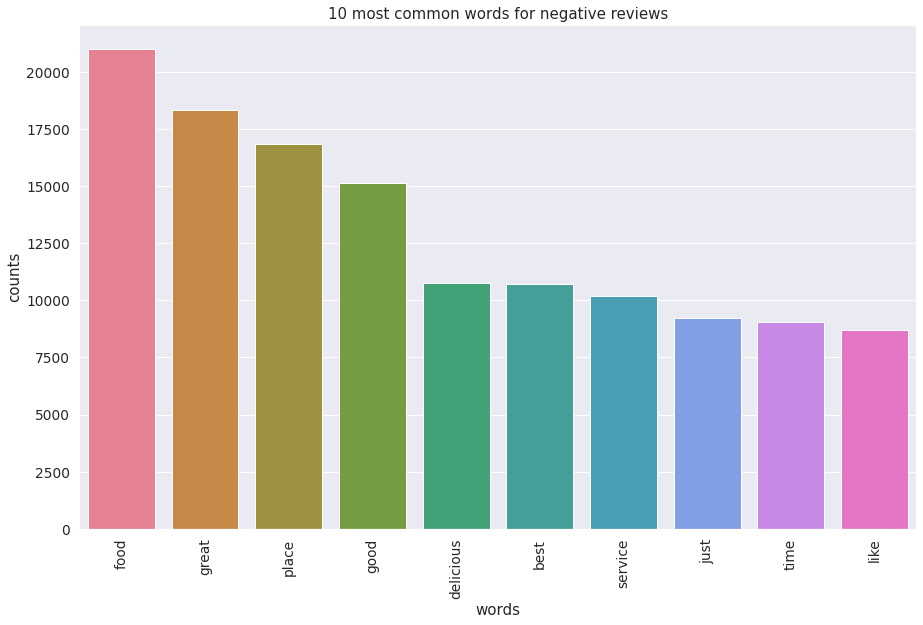

In [ ]:

def plot_10_most_common_words(count_data, count_vectorizer):
    words = count_vectorizer.get_feature_names_out()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words for negative reviews')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x=x_pos, y=counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
## Sentiment Analysis for high rated reviews
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(positive_reviews['text'])

# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

In [ ]:
# Let's use the stop_words argument to remove words like "and, the, a"
cvec = CountVectorizer(min_df = 2, stop_words= stop_words, max_features = 1000)

cvec.fit(positive_reviews['text'])

positive_words = pd.DataFrame(cvec.transform(positive_reviews['text']).todense(),
                       columns=cvec.get_feature_names_out())

positive_top = positive_words.sum(axis = 0).sort_values(ascending = False).head(100)
positive_pd = pd.DataFrame(data=positive_top)
positive_top = positive_words[positive_pd.index]
positive_top.drop(columns=['food','like', 'restaurant', 'place', 'really'], inplace = True)
positive_top.head()

<ipython-input-38-00fb226d8933>:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,great,delicious,best,service,one,time,back,amazing,philly,definitely,love,menu,well,got,cheese,always,chicken,ordered,staff,us,everything,friendly,order,favorite,fresh,...,sure,loved,better,dish,dishes,highly,next,philadelphia,dessert,new,around,top,fried,pretty,going,area,hot,taste,still,special,flavor,absolutely,friends,beer,coffee
0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


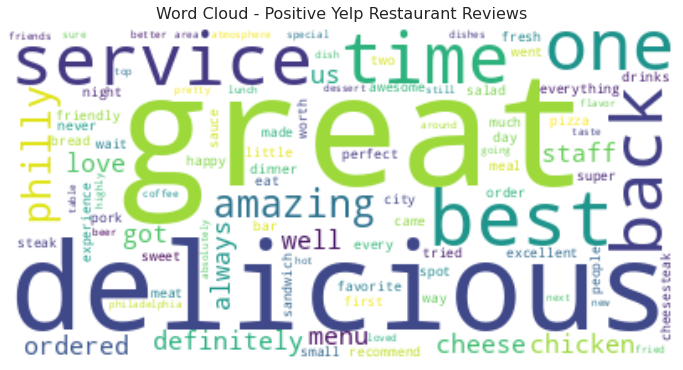

In [ ]:
# Generate Word Cloud

wordcloud_high = WordCloud(background_color="white").generate(' '.join(positive_top))
plt.figure(figsize = (12,10))
plt.imshow(wordcloud_high, interpolation='bilinear')
plt.title('Word Cloud - Positive Yelp Restaurant Reviews', fontsize=16, y=1.01)
plt.axis("off");

In [ ]:
positive_reviews['counter'] = 1
positive_reviews.head()

<ipython-input-40-d84df0d730bb>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,business_id,review_id,user_id,stars,useful,funny,cool,text,date,counter
1,cPDX2Y4H0fks-Qj5tfBduA,Dsz8hsLQNDJntT45PxG4HQ,ubPlKiHayyv2puouC1faMQ,5,0,0,0,An enchantingly wonderful happy place! Tartes...,2016-03-04 23:56:35,1
2,cPDX2Y4H0fks-Qj5tfBduA,d6HqIoLPBkBGE_eME6P3aA,0ENLV8uFNuZEehc48HwYzw,5,1,0,1,"Perfect coconut, key lime and apple crumb tart...",2012-04-14 19:32:15,1
3,cPDX2Y4H0fks-Qj5tfBduA,Q3J7dLtHWX_JTkiLIBs0vw,ouODopBKF3AqfCkuQEnrDg,5,1,0,1,The tarts here are fantastic. I love the crem...,2010-07-05 18:43:25,1
5,cPDX2Y4H0fks-Qj5tfBduA,8_0PyYnv49a97zEpfLD_Rw,Aqc1hcRcFa1pqjL0nPEuWQ,5,0,0,0,Lemon tart was so GOOD! I wouldn't recommend t...,2015-04-27 20:22:41,1
9,cPDX2Y4H0fks-Qj5tfBduA,aX-_Q93O7QfP6-1plmPGMA,Q5I2xTcaQ22bmE_mp2q_Rw,5,2,0,2,The outside looks like a parking lot structure...,2007-09-05 22:12:26,1


In [ ]:
# Sorting Restaurants Based on Most Reviews

positive_reviews.groupby('business_id')['counter'].sum().sort_values(ascending = False)

business_id
ctHjyadbDQAtUFfkcAFEHw    2038
RQAF6a0akMiot5lZZnMNNw    1381
j-qtdD55OLfSqfsWuQTDJg     715
-mIlmp5l4hKlp1tvHRdvTg     614
-cEFKAznWmI0cledNOIQ7w     576
                          ... 
_km1lWcqrx09hh8DvgVtBg       1
rjjK00bgGHNOJWMgUXT-ng       1
YXqqSPG3M3-pnJW9FjQfWg       1
tqY2t5a5E6YQKfW4jL8Vfg       1
ejg5XYqnNmPjtwjeFU5GaQ       1
Name: counter, Length: 676, dtype: int64

In [ ]:
# Restaurant with most positive reviews

best_restaurant = business_final[business_final['business_id'] == 'ctHjyadbDQAtUFfkcAFEHw']
best_restaurant

,index,business_id,name,city,state,stars,review_count,categories,latitude,longitude,postal_code
769,31165,ctHjyadbDQAtUFfkcAFEHw,Zahav,Philadelphia,PA,4.5,3065,"Nightlife, Bars, Food, Ethnic Food, Middle Eas...",39.946261,-75.145135,19106


In [ ]:
best_restaurant_reviews = positive_reviews[positive_reviews['business_id'] == 'ctHjyadbDQAtUFfkcAFEHw']
best_restaurant_reviews

,business_id,review_id,user_id,stars,useful,funny,cool,text,date,counter
37479,ctHjyadbDQAtUFfkcAFEHw,aU8tQnFO-Wdbo325Ax7f1A,XZxMgbZiaXuCTb0l--RoUg,5,0,0,0,date night with girlfriend here was perfect. i...,2014-04-19 12:20:39,1
37480,ctHjyadbDQAtUFfkcAFEHw,9MFyPkP0wjHMyx18tlF3Pg,nkBpODDjnP-nD9uz1Z4YsA,5,2,0,0,Can't say enough good things about Zahav! This...,2015-12-05 15:05:04,1
37481,ctHjyadbDQAtUFfkcAFEHw,939yCAYbEWUwoG8BHyskrQ,FC1ZSB9fd4WlDMSAbEjq8Q,5,2,0,1,"As a foodie, I spend a lot of time researching...",2018-09-14 14:25:32,1
37482,ctHjyadbDQAtUFfkcAFEHw,Fi-fRDDSrEIppbSC75iYqg,YCIIVcEdGB1MxRH0FfHc3g,5,0,0,0,"I think about that Vanessa Carlton line: ""you ...",2014-10-11 14:46:36,1
37483,ctHjyadbDQAtUFfkcAFEHw,ToTMuvRe_l01iSEMSfxLCA,cR5bvpc0xeQpm-Bsx67A8w,5,0,0,0,"Like another reviewer, I had been a bit underw...",2012-02-01 03:44:12,1
...,...,...,...,...,...,...,...,...,...,...
40320,ctHjyadbDQAtUFfkcAFEHw,21OLe-jFJ08izcn-0Rfd7w,eurcUfnJQsHJ73yoaemD2g,5,1,0,1,5 year anniversary celebration couldn't have b...,2021-04-27 14:47:22,1
40321,ctHjyadbDQAtUFfkcAFEHw,-MCFgXzWlN_GVMTuiaVTrQ,jGd-4ntmtGGEWj7CpS3Tmg,5,0,0,0,So bomb! Very hard to get a reservation even a...,2020-02-11 02:31:05,1
40322,ctHjyadbDQAtUFfkcAFEHw,5-bpyVHVeO73jv_sZ8s3Dw,N9hqTPQu2bmI8c2Pj8F1ww,5,7,2,4,I made my reservation three weeks in advance f...,2015-01-26 14:12:50,1
40323,ctHjyadbDQAtUFfkcAFEHw,DRupz28E9Aji9Q-Py23HrQ,JaqcCU3nxReTW2cBLHounA,5,2,0,0,Zahav is by far the best bang for your back in...,2019-12-26 01:12:51,1


In [ ]:
# Let's use the stop_words argument to remove words like "and, the, a"
cvec = CountVectorizer(min_df = 2, stop_words= stop_words, max_features = 1000)

cvec.fit(best_restaurant_reviews['text'])

positive_words = pd.DataFrame(cvec.transform(best_restaurant_reviews['text']).todense(),
                       columns=cvec.get_feature_names_out())

positive_top = positive_words.sum(axis = 0).sort_values(ascending = False).head(300)
positive_pd = pd.DataFrame(data=positive_top)
positive_top = positive_words[positive_pd.index]
positive_top.drop(columns=['food','like', 'restaurant', 'place', 'really','great','menu','zahav'], inplace = True)
positive_top.head()

<ipython-input-44-edfc4c2d7682>:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,hummus,one,service,best,lamb,amazing,delicious,us,tasting,dishes,time,meal,experience,everything,dish,got,well,cauliflower,dessert,ever,fried,back,reservation,small,every,...,whole,selection,tehina,mouth,hype,trying,mint,looking,felt,interesting,early,vegetarian,comes,hot,texture,high,extremely,share,ha,year,variety,husband,hour,yet,remember
0,0,0,2,0,1,3,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,1,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,2,1,0,0,0,1,3,2,1,0,0,0,5,1,0,0,1,0,0,0,1,1,0,0,2,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,4,1,0,0,0,3,0,0,0,3,4,1,1,1,2,1,3,1,0,0,1,1,1,2,0,...,2,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
3,0,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,2,4,0,0,1,0,0,0,2,0,4,2,0,2,0,1,0,1,0,0,1,0,2,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:

column_list = list(positive_top)
positive_words = positive_top[column_list].sum(axis=0)
positive_words = positive_words.to_frame(name = 'sum').reset_index()
positive_words.set_index('index',inplace = True)
positive_words.to_csv("/content/gdrive/MyDrive/restaurant recomendation system/positive_words.csv")

In [ ]:
thumbs_up = stylecloud.gen_stylecloud(file_path="/content/gdrive/MyDrive/restaurant recomendation system/positive_words.csv", 
                                        icon_name = "fas fa-thumbs-up",
                                        size = 550,
                                        palette="colorbrewer.sequential.Greens_5", 
                                        background_color="white",
                                        output_name = '/content/gdrive/MyDrive/restaurant recomendation system/Positive_Reviews.png')

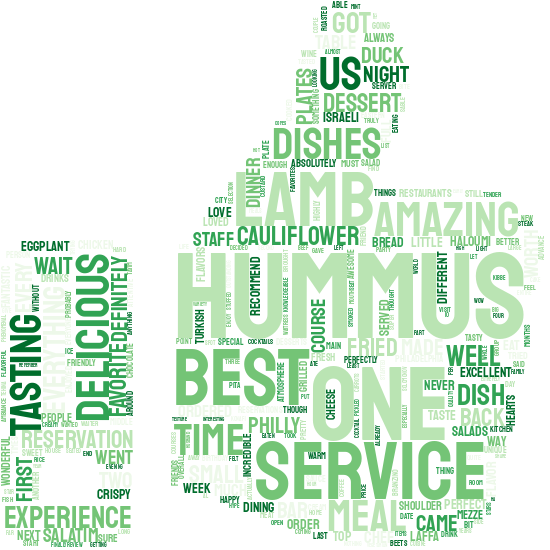

In [ ]:
Image(filename='/content/gdrive/MyDrive/restaurant recomendation system/Positive_Reviews.png')


New Features

In [ ]:
## Creating new feature columns
# Calculate reviews word count

review_final['word_count'] = review_final['text'].apply(lambda x: len(str(x).split(" ")))

# Calculate reviews character count

review_final['char_count'] = review_final['text'].str.len()

# Calculate average review length

def avg_word(review):
  words = review.split()
  return (sum(len(word) for word in words) / len(words))

review_final['avg_word_len'] = review_final['text'].apply(lambda x: avg_word(x))

# Calculate number of stop words in reviews

from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))
review_final['stopword_count'] = review_final['text'].apply(lambda x: len([x for x in x.split() if x in stopwords]))

review_final.head()

,business_id,review_id,user_id,stars,useful,funny,cool,text,date,word_count,char_count,avg_word_len,stopword_count
0,cPDX2Y4H0fks-Qj5tfBduA,YP4dpdLt7iomIJGIweKTjg,K97i0e7MaxYfvCCwPFMjuw,3,0,0,0,This is solely for the cupcakes. So I retuned ...,2011-07-24 17:44:29,109,582,4.348624,44
1,cPDX2Y4H0fks-Qj5tfBduA,Dsz8hsLQNDJntT45PxG4HQ,ubPlKiHayyv2puouC1faMQ,5,0,0,0,An enchantingly wonderful happy place! Tartes...,2016-03-04 23:56:35,48,264,4.617021,17
2,cPDX2Y4H0fks-Qj5tfBduA,d6HqIoLPBkBGE_eME6P3aA,0ENLV8uFNuZEehc48HwYzw,5,1,0,1,"Perfect coconut, key lime and apple crumb tart...",2012-04-14 19:32:15,54,302,4.611111,18
3,cPDX2Y4H0fks-Qj5tfBduA,Q3J7dLtHWX_JTkiLIBs0vw,ouODopBKF3AqfCkuQEnrDg,5,1,0,1,The tarts here are fantastic. I love the crem...,2010-07-05 18:43:25,52,282,4.714286,18
4,cPDX2Y4H0fks-Qj5tfBduA,tglKErAzBSzBaEddqoShiA,jGUdsAMkurKYZCh6l84n7w,4,0,0,0,"Third trip to Tartes, third time I've been sat...",2012-01-01 21:02:34,214,1121,4.161290,97


<ipython-input-49-2ad5ac47709f>:5: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




Text(0, 0.5, 'Percentage of Reviews')

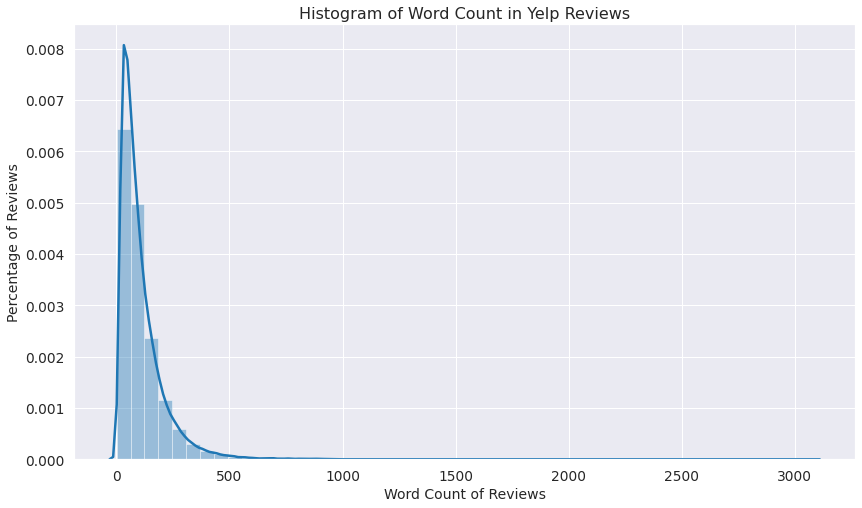

In [ ]:
# Histogram of Word Count of Yelp Reviews

sns.set_style("darkgrid")
plt.figure(figsize=(14,8))
sns.distplot(review_final['word_count'])
plt.title('Histogram of Word Count in Yelp Reviews', fontsize = 16)
plt.xlabel('Word Count of Reviews', fontsize=14)
plt.ylabel('Percentage of Reviews', fontsize=14)

<ipython-input-50-45c83731b8d5>:5: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




Text(0, 0.5, 'Percentage of Reviews')

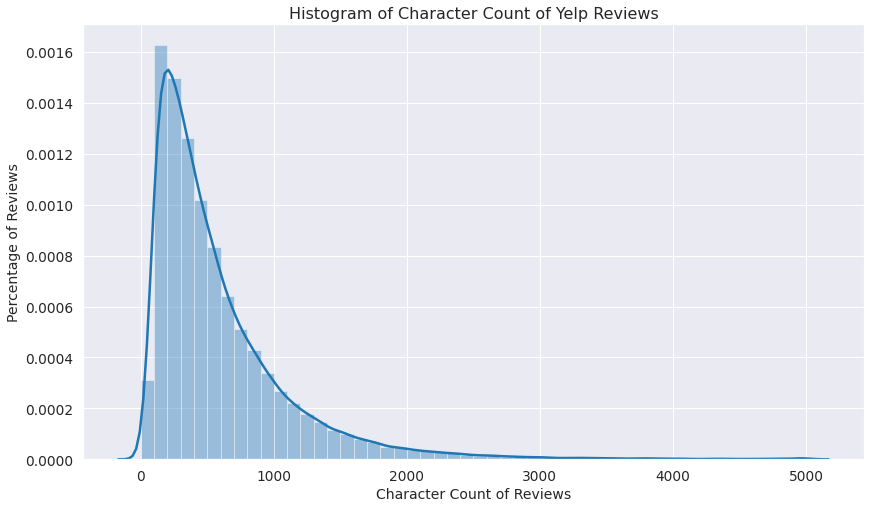

In [ ]:
# Histogram of Character Count of Yelp Reviews

sns.set_style("darkgrid")
plt.figure(figsize=(14,8))
sns.distplot(review_final['char_count'])
plt.title('Histogram of Character Count of Yelp Reviews', fontsize = 16)
plt.xlabel('Character Count of Reviews', fontsize=14)
plt.ylabel('Percentage of Reviews', fontsize=14)

<ipython-input-51-ee5f644b4c4b>:5: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




Text(0, 0.5, 'Percentage of Restaurants')

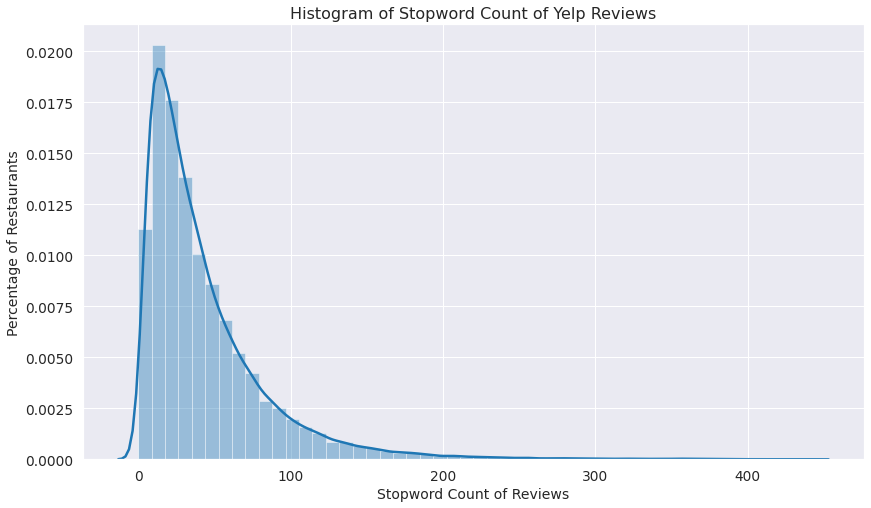

In [ ]:
# Histogram of Stopword Count of Yelp Reviews

sns.set_style("darkgrid")
plt.figure(figsize=(14,8))
sns.distplot(review_final['stopword_count'])
plt.title('Histogram of Stopword Count of Yelp Reviews', fontsize = 16)
plt.xlabel('Stopword Count of Reviews', fontsize=14)
plt.ylabel('Percentage of Restaurants', fontsize=14)

In [ ]:
# Average Word Length of Review for different Stars/Ratings
review_final.groupby('stars')['word_count'].mean()

stars
1    121.627407
2    133.347567
3    127.264542
4    114.786791
5     92.591299
Name: word_count, dtype: float64

In [ ]:
stars_wordcount = review_final.groupby('stars')['word_count'].mean()
stars_wordcount = stars_wordcount.to_frame(name = 'sum').reset_index()
stars_wordcount

,stars,sum
0,1,121.627407
1,2,133.347567
2,3,127.264542
3,4,114.786791
4,5,92.591299


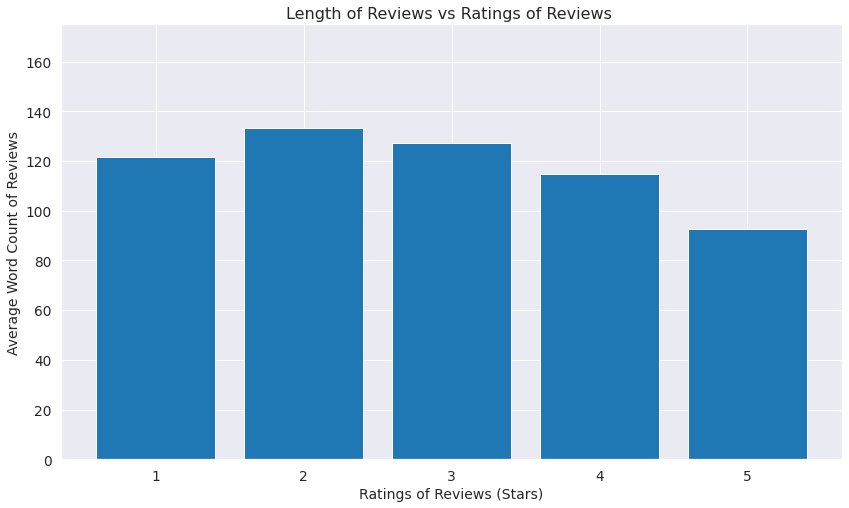

In [ ]:
# Distribution of Length of Reviews vs Ratings of Reviews

sns.set_style("darkgrid")
plt.figure(figsize=(14,8))
plt.bar(stars_wordcount['stars'],stars_wordcount['sum'])
plt.title('Length of Reviews vs Ratings of Reviews ', fontsize = 16)
plt.xlabel('Ratings of Reviews (Stars)', fontsize=14)
plt.ylabel('Average Word Count of Reviews', fontsize=14)
plt.ylim((0,175))
plt.show()

Text Processing

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# Import Textblob

from textblob import Word

# Splitting up words in reviews

review_final['cleaned_text'] = review_final['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))

# Remove Punctuation

review_final['cleaned_text'] = review_final['cleaned_text'].str.replace('[^\w\s]', '')

# Remove Stopwords

from nltk.corpus import stopwords
review_final['cleaned_text'] = review_final['cleaned_text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop_words))

# Lemmatizing cleaned text

#review_final['cleaned_text'] = review_final['cleaned_text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
review_final.head()

<ipython-input-56-445dd931e841>:11: FutureWarning:

The default value of regex will change from True to False in a future version.



,business_id,review_id,user_id,stars,useful,funny,cool,text,date,word_count,char_count,avg_word_len,stopword_count,cleaned_text
0,cPDX2Y4H0fks-Qj5tfBduA,YP4dpdLt7iomIJGIweKTjg,K97i0e7MaxYfvCCwPFMjuw,3,0,0,0,This is solely for the cupcakes. So I retuned ...,2011-07-24 17:44:29,109,582,4.348624,44,solely cupcakes retuned tartes sweet treats co...
1,cPDX2Y4H0fks-Qj5tfBduA,Dsz8hsLQNDJntT45PxG4HQ,ubPlKiHayyv2puouC1faMQ,5,0,0,0,An enchantingly wonderful happy place! Tartes...,2016-03-04 23:56:35,48,264,4.617021,17,enchantingly wonderful happy place tartes favo...
2,cPDX2Y4H0fks-Qj5tfBduA,d6HqIoLPBkBGE_eME6P3aA,0ENLV8uFNuZEehc48HwYzw,5,1,0,1,"Perfect coconut, key lime and apple crumb tart...",2012-04-14 19:32:15,54,302,4.611111,18,perfect coconut key lime apple crumb tarts alw...
3,cPDX2Y4H0fks-Qj5tfBduA,Q3J7dLtHWX_JTkiLIBs0vw,ouODopBKF3AqfCkuQEnrDg,5,1,0,1,The tarts here are fantastic. I love the crem...,2010-07-05 18:43:25,52,282,4.714286,18,tarts fantastic love creme brulee hazelnut tru...
4,cPDX2Y4H0fks-Qj5tfBduA,tglKErAzBSzBaEddqoShiA,jGUdsAMkurKYZCh6l84n7w,4,0,0,0,"Third trip to Tartes, third time I've been sat...",2012-01-01 21:02:34,214,1121,4.161290,97,third trip tartes third time ive satisfied fir...


Text Classification Using Textblob
Sentiment analysis is the process of determining the attitude or the emotion of the writer/user, i.e., whether it is positive or negative or neutral.

The sentiment function of textblob returns two properties: polarity and subjectivity.

Polarity is float which lies in the range of [-1,1] where 1 means positive statement and -1 means a negative statement.

Subjective sentences generally refer to personal opinion, emotion or judgment whereas objective refers to factual information. Subjectivity is also a float which lies in the range of [0,1].

In [ ]:
# Calculate polarity and subjectivity score

from textblob import TextBlob

review_final['polarity'] = review_final['cleaned_text'].apply(lambda x: TextBlob(x).sentiment[0])
review_final['subjectivity'] = review_final['cleaned_text'].apply(lambda x: TextBlob(x).sentiment[1])
review_final.head(3)

,business_id,review_id,user_id,stars,useful,funny,cool,text,date,word_count,char_count,avg_word_len,stopword_count,cleaned_text,polarity,subjectivity
0,cPDX2Y4H0fks-Qj5tfBduA,YP4dpdLt7iomIJGIweKTjg,K97i0e7MaxYfvCCwPFMjuw,3,0,0,0,This is solely for the cupcakes. So I retuned ...,2011-07-24 17:44:29,109,582,4.348624,44,solely cupcakes retuned tartes sweet treats co...,-0.060185,0.304630
1,cPDX2Y4H0fks-Qj5tfBduA,Dsz8hsLQNDJntT45PxG4HQ,ubPlKiHayyv2puouC1faMQ,5,0,0,0,An enchantingly wonderful happy place! Tartes...,2016-03-04 23:56:35,48,264,4.617021,17,enchantingly wonderful happy place tartes favo...,0.500000,0.800000
2,cPDX2Y4H0fks-Qj5tfBduA,d6HqIoLPBkBGE_eME6P3aA,0ENLV8uFNuZEehc48HwYzw,5,1,0,1,"Perfect coconut, key lime and apple crumb tart...",2012-04-14 19:32:15,54,302,4.611111,18,perfect coconut key lime apple crumb tarts alw...,0.334375,0.634615


Vader Sentiment Analysis
VADER (Valence Aware Dictionary and Sentiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media. VADER uses a combination of lexical features (e.g. words) which are generally labelled according to their semantic orientation as either positive or negative.

VADER has been found to be quite successful when dealing with social media texts, NY Times editorials, movie reviews, and product reviews. This is because VADER not only tells us about the Positivity and Negativity score but also tells us about how positive or negative a sentiment is through the compound score.

The compound score is computed by summing the valence scores of each word in the lexicon, adjusted according to the rules, and then normalized to be between -1 (most extreme negative) and +1 (most extreme positive).

In [ ]:
# Calculate Vader Sentiment Analysis Scores

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

sentiment = review_final['text'].apply(lambda x: analyzer.polarity_scores(x))
review_final = pd.concat([review_final,sentiment.apply(pd.Series)],1)
review_final.sample(5)

<ipython-input-58-7e7ab1740ee8>:7: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.



,business_id,review_id,user_id,stars,useful,funny,cool,text,date,word_count,char_count,avg_word_len,stopword_count,cleaned_text,polarity,subjectivity,neg,neu,pos,compound
67399,NABcZKRWQF9-rDVt0P0bhw,maT0s8st3g2XY5k7Q871EA,JgbLN70Wv-IhrSiqCTeW2Q,1,0,0,0,We came in on a Sunday for dim sum. If you're ...,2021-09-05 18:46:31,130,696,4.361538,47,came sunday dim sum youre familiar dim sum chi...,-0.066737,0.478711,0.100,0.874,0.027,-0.9070
76111,oIr50siZDtDYCE_p5K8nYA,JIfHvl2gYr4AHKoIOeYGcw,ntqURA0yzrFadofEZNwIyw,5,5,0,2,Hands down my new favorite brunch spot! I did ...,2019-06-25 01:18:46,221,1238,4.547085,84,hands new favorite brunch spot prixfixe brunch...,0.277016,0.528024,0.000,0.810,0.190,0.9935
47312,wB1Tin0OW1JRpaKM-E3ZYA,9BxbeEjVlfbxPxqVOSVeCg,kO30XR2WeF6bla6dK1ZZLw,4,0,0,0,Cheap drinks - decent music - decent atmospher...,2012-08-27 00:52:38,30,162,4.300000,5,cheap drinks decent music decent atmosphere pl...,0.141667,0.633333,0.000,0.937,0.063,0.2382
51401,Rzx2E5XgTeGU7FEbUZ-bGg,nR9zurAskgLG5NUdcA-KUw,0nRFdf0Ruw18EbyEvXoAXw,4,0,0,0,The vast majority of my furniture has come fro...,2018-07-07 18:07:01,87,481,4.540230,35,vast majority furniture ikea owned pieces year...,0.164205,0.466667,0.037,0.797,0.166,0.8999
12942,j-qtdD55OLfSqfsWuQTDJg,nqQaxV0UF5qdRxGU9Lmi7g,yESVHMBq-7GUbcVK4Z1LsA,4,0,0,0,Went here for brunch with family and friends. ...,2019-12-08 17:01:15,157,880,4.585987,64,went brunch family friends place packed saturd...,0.330867,0.434439,0.015,0.783,0.202,0.9900


In [ ]:
sentiment
type(review_final.compound)

pandas.core.series.Series

<ipython-input-60-76f63fe2c281>:6: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




Text(0, 0.5, 'Percentage of Restaurants')

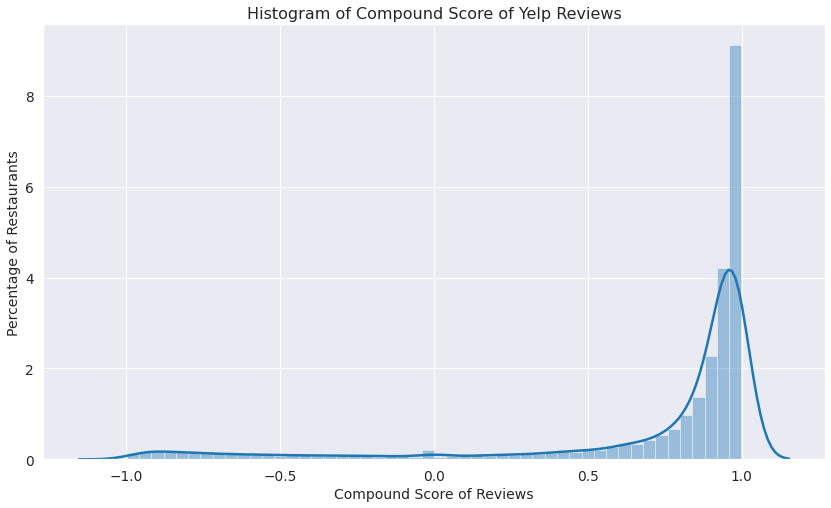

In [ ]:
# Histogram of Compound Score of Yelp Reviews
review_final['compound_score'] = review_final['compound'].apply(lambda x: x.get('compound', 0) if isinstance(x, dict) else x)

sns.set_style("darkgrid")
plt.figure(figsize=(14,8))
sns.distplot(review_final['compound_score'])
plt.title('Histogram of Compound Score of Yelp Reviews', fontsize = 16)
plt.xlabel('Compound Score of Reviews', fontsize=14)
plt.ylabel('Percentage of Restaurants', fontsize=14)


<ipython-input-61-971d5000686c>:5: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




Text(0, 0.5, 'Percentage of Restaurants')

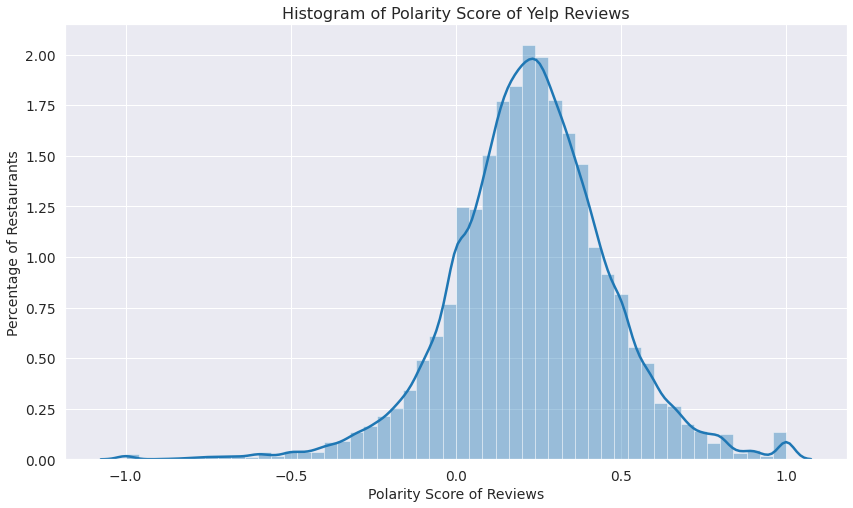

In [ ]:
# Histogram of Polarity Score of Yelp Reviews

sns.set_style("darkgrid")
plt.figure(figsize=(14,8))
sns.distplot(review_final['polarity'])
plt.title('Histogram of Polarity Score of Yelp Reviews', fontsize = 16)
plt.xlabel('Polarity Score of Reviews', fontsize=14)
plt.ylabel('Percentage of Restaurants', fontsize=14)

<ipython-input-62-fe5d6fb60745>:5: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




Text(0, 0.5, 'Percentage of Restaurants')

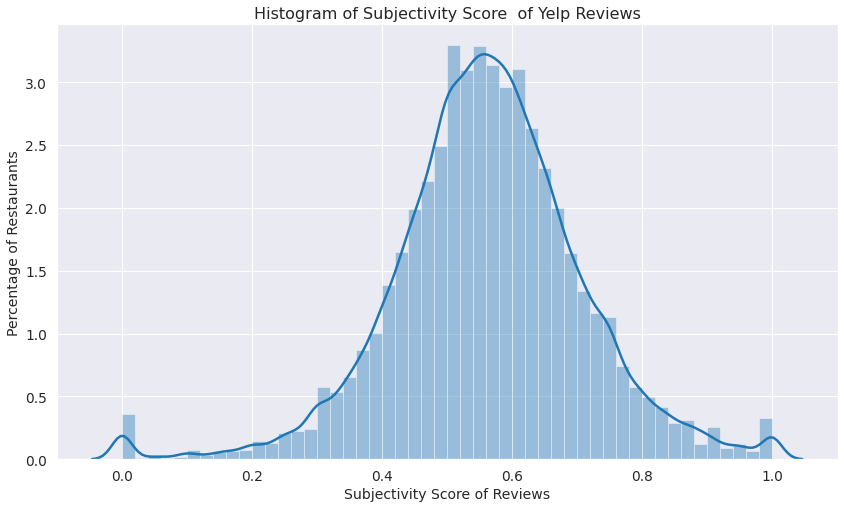

In [ ]:
# Histogram of Subjectivity Score of Yelp Reviews

sns.set_style("darkgrid")
plt.figure(figsize=(14,8))
sns.distplot(review_final['subjectivity'])
plt.title('Histogram of Subjectivity Score  of Yelp Reviews', fontsize = 16)
plt.xlabel('Subjectivity Score of Reviews', fontsize=14)
plt.ylabel('Percentage of Restaurants', fontsize=14)

In [ ]:
review_final.shape


(78410, 21)

In [ ]:
# create a list of our conditions
conditions = [
    (review_final['stars'] <= 2.0),
    (review_final['stars'] == 3.0 ),
    (review_final['stars'] >= 4.0)
    ]

# create a list of the values we want to assign for each condition
values = ['negative', 'neutral', 'positive']

# create a new column and use np.select to assign values to it using our lists as arguments
review_final['sentiment'] = np.select(conditions, values)

# display updated DataFrame
review_final.head()

,business_id,review_id,user_id,stars,useful,funny,cool,text,date,word_count,char_count,avg_word_len,stopword_count,cleaned_text,polarity,subjectivity,neg,neu,pos,compound,compound_score,sentiment
0,cPDX2Y4H0fks-Qj5tfBduA,YP4dpdLt7iomIJGIweKTjg,K97i0e7MaxYfvCCwPFMjuw,3,0,0,0,This is solely for the cupcakes. So I retuned ...,2011-07-24 17:44:29,109,582,4.348624,44,solely cupcakes retuned tartes sweet treats co...,-6.018519e-02,0.304630,0.074,0.844,0.082,-0.0066,-0.0066,neutral
1,cPDX2Y4H0fks-Qj5tfBduA,Dsz8hsLQNDJntT45PxG4HQ,ubPlKiHayyv2puouC1faMQ,5,0,0,0,An enchantingly wonderful happy place! Tartes...,2016-03-04 23:56:35,48,264,4.617021,17,enchantingly wonderful happy place tartes favo...,5.000000e-01,0.800000,0.000,0.662,0.338,0.9682,0.9682,positive
2,cPDX2Y4H0fks-Qj5tfBduA,d6HqIoLPBkBGE_eME6P3aA,0ENLV8uFNuZEehc48HwYzw,5,1,0,1,"Perfect coconut, key lime and apple crumb tart...",2012-04-14 19:32:15,54,302,4.611111,18,perfect coconut key lime apple crumb tarts alw...,3.343750e-01,0.634615,0.016,0.727,0.257,0.9507,0.9507,positive
3,cPDX2Y4H0fks-Qj5tfBduA,Q3J7dLtHWX_JTkiLIBs0vw,ouODopBKF3AqfCkuQEnrDg,5,1,0,1,The tarts here are fantastic. I love the crem...,2010-07-05 18:43:25,52,282,4.714286,18,tarts fantastic love creme brulee hazelnut tru...,4.321429e-01,0.734127,0.000,0.621,0.379,0.9698,0.9698,positive
4,cPDX2Y4H0fks-Qj5tfBduA,tglKErAzBSzBaEddqoShiA,jGUdsAMkurKYZCh6l84n7w,4,0,0,0,"Third trip to Tartes, third time I've been sat...",2012-01-01 21:02:34,214,1121,4.161290,97,third trip tartes third time ive satisfied fir...,9.796086e-18,0.422549,0.078,0.791,0.131,0.9266,0.9266,positive


In [ ]:
#Saving to CSv

In [ ]:
# # Save combined_reviews into csv file

review_final.to_csv("/content/gdrive/MyDrive/restaurant recomendation system/sentiment_reviews.csv")

In [ ]:
combined_reviews = review_final.copy()

Topic Modelling
Topic modeling is a type of statistical modeling for discovering the abstract “topics” that occur in a collection of documents. Latent Dirichlet Allocation (LDA) is an example of topic modelling and it is used to classify text in a document to a particular topic. It builds a topic per document model and words per topic model, modeled as Dirichlet distributions.

In [ ]:
dropped_reviews = combined_reviews[(combined_reviews.polarity ==0.0) & (combined_reviews.compound==0.0) & (combined_reviews.subjectivity==0.0)]
print(dropped_reviews.shape)
dropped_reviews.sample(5)

(150, 22)


,business_id,review_id,user_id,stars,useful,funny,cool,text,date,word_count,char_count,avg_word_len,stopword_count,cleaned_text,polarity,subjectivity,neg,neu,pos,compound,compound_score,sentiment
10920,0ak-7uV9Nb7nF_l-mMCysA,6Z4URZhfqHunwLBn47B1yQ,JhsaQkdLjU9OOD-wuODOew,5,0,0,0,Woo......第一次尝试，好看又好吃！！！环境也很好服务态度也超好的 给99分吧...,2016-09-17 00:47:30,19,95,15.400000,0,woo第一次尝试好看又好吃环境也很好服务态度也超好的 给99分吧 怕他们骄傲 终于终于找到c...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,positive
34525,-mIlmp5l4hKlp1tvHRdvTg,qZDtVnMDaxpHLtkncEaqxw,SJw3f0HghdgRrusyKoSxUA,5,0,0,0,"YUMMMM! hubbie had provolone, onion I went for...",2014-08-27 01:44:11,18,88,3.944444,7,yummmm hubbie provolone onion went wiz mmmm cr...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,positive
29939,cGX-1IUwXOjkUqZbkKYcjw,xlfIK_e9UvVKb7FiAE2YPw,AzLRc_ENN_-83N1HVwjF8A,5,1,0,0,Absolut 6 Sterne! Brasilianisches BBQ zig Fle...,2013-08-08 22:44:38,46,276,5.133333,4,absolut 6 sterne brasilianisches bbq zig fleis...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,positive
64079,vwAhm3pRjCEz_jNXr9vMaA,N0N2QLnvjJHQKIc7sB0yzA,EH6U-Ni1jJndh7eI_DAUxA,1,2,0,0,第一次来费城，看到评价很高就来了，结果。。。。发自内心的说一句，特别特别不适合中国人的口味，...,2015-01-02 17:30:59,1,115,115.000000,0,第一次来费城看到评价很高就来了结果发自内心的说一句特别特别不适合中国人的口味千万别来吃啊面包...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,negative
16745,6x9hcZ1CJ4S9avBgPGS7-Q,Hr2gWdB0zo4fJmfOKAQ2CA,AiAlVIsa8o-3x2l7-ue7Ng,1,1,1,0,The daytime bartender had the audacity to tell...,2018-09-25 17:18:30,18,90,4.055556,7,daytime bartender audacity tell us works tips 20,0.0,0.0,0.0,1.0,0.0,0.0,0.0,negative


In [ ]:
# Dropping these filtered rows

combined_reviews = combined_reviews.drop(index = dropped_reviews.index)
print(combined_reviews.shape)
combined_reviews.sample(3)

(78260, 22)


,business_id,review_id,user_id,stars,useful,funny,cool,text,date,word_count,char_count,avg_word_len,stopword_count,cleaned_text,polarity,subjectivity,neg,neu,pos,compound,compound_score,sentiment
22634,8j3blTZChklt3j89jxx0fw,QZ-XufgzTo4Wm26uZ7h0sA,ojc6MnSQqTN4S0-ibVsUVg,4,2,0,1,[This review was made in 10/2020 during the CO...,2020-10-20 01:26:27,242,1337,4.448980,111,review made 102020 covid19 pandemic friend int...,0.078333,0.458333,0.0,0.848,0.152,0.9922,0.9922,positive
33366,KfIPQSLSj_rJ9zbsdO7wFQ,KeHi2XB3JXCzBkPLqt4G8g,Nbuce0D03EQdaGND4xEotA,4,0,0,0,"This place is tiny, busy, but comfortable. We ...",2015-12-20 02:47:48,94,487,4.191489,39,place tiny busy comfortable wait outside 15 mi...,0.225000,0.422593,0.0,0.781,0.219,0.9792,0.9792,positive
61458,LO5yBY9uoowtq7FsaKPJXA,FbIvYx6vneoVdoGq1msCrw,V2s2VCuegQzRvI0DXWk6dQ,4,1,0,0,"Great atmosphere, the food was good enough, we...",2013-07-06 21:11:10,32,175,4.500000,14,great atmosphere food enough apps cannot reall...,0.355000,0.570000,0.0,0.676,0.324,0.9245,0.9245,positive


In [ ]:
# Converting words in reviews to a list

def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list

data = combined_reviews.text.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

[['this', 'is', 'solely', 'for', 'the', 'cupcakes', 'so', 'retuned', 'to', 'tartes', 'for', 'more', 'of', 'their', 'sweet', 'treats', 'how', 'convenient', 'that', 'this', 'place', 'is', 'located', 'on', 'my', 'way', 'home', 'from', 'working', 'out', 'negates', 'all', 'the', 'calories', 'try', 'so', 'hard', 'to', 'burn', 'in', 'any', 'case', 'definitely', 'wont', 'be', 'back', 'for', 'cupcakes', 'at', 'tartes', 'ordered', 'red', 'velvet', 'and', 'vanilla', 'and', 'ended', 'up', 'with', 'chocolate', 'and', 'vanilla', 'bummer', 'but', 'not', 'big', 'deal', 'cupcake', 'is', 'cupcake', 'right', 'these', 'cupcakes', 'were', 'so', 'disappointing', 'they', 'tasted', 'like', 'cake', 'you', 'could', 'buy', 'at', 'your', 'local', 'grocery', 'store', 'the', 'frosting', 'was', 'equally', 'uninspiring', 'might', 'as', 'well', 'head', 'to', 'acme']]


In [ ]:
# Text Processing

import spacy

def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)

In [ ]:
# Create Dictionary

id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency

corpus = [id2word.doc2bow(text) for text in data_ready]

In [ ]:
# Build LDA model

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5,
                                           random_state=42,
                                           chunksize=250,
                                           passes=5,
                                           alpha='auto',
                                           iterations=10,
                                           per_word_topics=False)

In [ ]:
# Overview of Dominant Topics

pprint(lda_model.print_topics())

[(0,
  '0.020*"restaurant" + 0.019*"dish" + 0.018*"meal" + 0.012*"raman" + '
  '0.011*"menu" + 0.011*"portion" + 0.011*"salad" + 0.010*"dinner" + '
  '0.010*"wine" + 0.009*"serve"'),
 (1,
  '0.051*"food" + 0.045*"place" + 0.026*"time" + 0.021*"well" + 0.017*"eat" + '
  '0.016*"really" + 0.015*"service" + 0.013*"back" + 0.012*"price" + '
  '0.012*"find"'),
 (2,
  '0.058*"great" + 0.016*"friendly" + 0.015*"service" + 0.015*"staff" + '
  '0.014*"drink" + 0.013*"beer" + 0.012*"bar" + 0.012*"spot" + 0.012*"place" + '
  '0.012*"recommend"'),
 (3,
  '0.025*"order" + 0.025*"sauce" + 0.021*"bread" + 0.020*"pizza" + '
  '0.018*"sandwich" + 0.018*"fry" + 0.017*"meat" + 0.017*"cheese" + '
  '0.016*"chicken" + 0.016*"pork"'),
 (4,
  '0.035*"order" + 0.023*"wait" + 0.021*"table" + 0.016*"ask" + 0.012*"minute" '
  '+ 0.010*"time" + 0.010*"tell" + 0.009*"server" + 0.008*"service" + '
  '0.008*"leave"')]


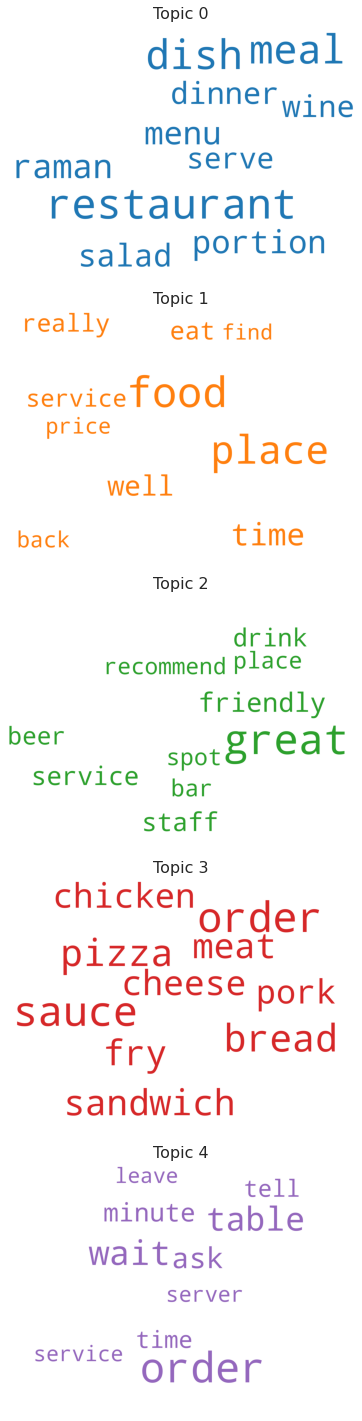

In [ ]:
# Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(5, 1, figsize=(20,20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [ ]:
# 5 topics

import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

/usr/local/lib/python3.9/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.199063  0.031304       1        1  27.692285
4     -0.189390  0.209298       2        1  20.294226
2     -0.065334 -0.298547       3        1  19.090999
0      0.142951 -0.049757       4        1  17.487209
3      0.310836  0.107703       5        1  15.435281, topic_info=        Term          Freq         Total Category  logprob  loglift
169    great  35985.000000  35985.000000  Default  30.0000  30.0000
26     place  47750.000000  47750.000000  Default  29.0000  29.0000
228     food  54521.000000  54521.000000  Default  28.0000  28.0000
25     order  37152.000000  37152.000000  Default  27.0000  27.0000
262     wait  14772.000000  14772.000000  Default  26.0000  26.0000
...      ...           ...           ...      ...      ...      ...
377   flavor   4136.752490   8148.153646   Topic5  -4.7895   1.1906
33     taste   4548.809382  12231.308286   Topic5  -4.6945   0.8794
31     sweet   3142.906215   5092.904942   Topic5  -5.0643   1.3858
1016     add   2755.827199   4344.030822   Topic5  -5.1957   1.4134
39      well   3093.816969  23456.980669   Topic5  -5.0800  -0.1572

[319 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
234       1  0.968690  absolutely
234       4  0.031065  absolutely
1016      1  0.007597         add
1016      2  0.126150         add
1016      3  0.030847         add
...     ...       ...         ...
149       1  0.996604       worth
149       5  0.003316       worth
701       1  0.999801        year
640       1  0.993536        yelp
640       2  0.005957        yelp

[508 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 3, 1, 4])

In [ ]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [ ]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)


<ipython-input-77-fca72f97606d>:15: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-77-fca72f97606d>:15: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [ ]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Keywords', 'Text']
print(df_dominant_topic.shape)
df_dominant_topic.head(10)

(78260, 4)


,Document_No,Dominant_Topic,Keywords,Text
0,0,1,"food, place, time, well, eat, really, service,...","[solely, cupcake, retune, tarte, sweet, treat,..."
1,1,1,"food, place, time, well, eat, really, service,...","[enchantingly, wonderful, happy, place, tarte,..."
2,2,1,"food, place, time, well, eat, really, service,...","[perfect, coconut, key, lime, apple, crumb, ta..."
3,3,0,"restaurant, dish, meal, raman, menu, portion, ...","[tart, fantastic, love, creme, hazelnut, truly..."
4,4,1,"food, place, time, well, eat, really, service,...","[third, trip, tarte, third, time, satisfy, fir..."
5,5,0,"restaurant, dish, meal, raman, menu, portion, ...","[tart, recommend, cupcake, ice, delicious, cak..."
6,6,2,"great, friendly, service, staff, drink, beer, ...","[love, little, window, concept, cute, pink, bu..."
7,7,0,"restaurant, dish, meal, raman, menu, portion, ...","[key, lime, tart, chocolate, creme, brulee, ta..."
8,8,0,"restaurant, dish, meal, raman, menu, portion, ...","[outside, look, parking, structure, paint, pin..."
9,9,1,"food, place, time, well, eat, really, service,...","[owner, sure, cocky, average, dessert]"


In [ ]:
# Append new columns onto reviews dataset

df_dominant_topic['Text_Chunks'] = df_dominant_topic['Text']
extra_feature_columns = df_dominant_topic[['Dominant_Topic', 'Keywords', 'Text_Chunks']]
final_reviews = pd.concat([combined_reviews,extra_feature_columns], axis=1).reindex(combined_reviews.index)
final_reviews.head(10)

,business_id,review_id,user_id,stars,useful,funny,cool,text,date,word_count,char_count,avg_word_len,stopword_count,cleaned_text,polarity,subjectivity,neg,neu,pos,compound,compound_score,sentiment,Dominant_Topic,Keywords,Text_Chunks
0,cPDX2Y4H0fks-Qj5tfBduA,YP4dpdLt7iomIJGIweKTjg,K97i0e7MaxYfvCCwPFMjuw,3.0,0.0,0.0,0.0,This is solely for the cupcakes. So I retuned ...,2011-07-24 17:44:29,109.0,582.0,4.348624,44.0,solely cupcakes retuned tartes sweet treats co...,-6.018519e-02,0.304630,0.074,0.844,0.082,-0.0066,-0.0066,neutral,1.0,"food, place, time, well, eat, really, service,...","[solely, cupcake, retune, tarte, sweet, treat,..."
1,cPDX2Y4H0fks-Qj5tfBduA,Dsz8hsLQNDJntT45PxG4HQ,ubPlKiHayyv2puouC1faMQ,5.0,0.0,0.0,0.0,An enchantingly wonderful happy place! Tartes...,2016-03-04 23:56:35,48.0,264.0,4.617021,17.0,enchantingly wonderful happy place tartes favo...,5.000000e-01,0.800000,0.000,0.662,0.338,0.9682,0.9682,positive,1.0,"food, place, time, well, eat, really, service,...","[enchantingly, wonderful, happy, place, tarte,..."
2,cPDX2Y4H0fks-Qj5tfBduA,d6HqIoLPBkBGE_eME6P3aA,0ENLV8uFNuZEehc48HwYzw,5.0,1.0,0.0,1.0,"Perfect coconut, key lime and apple crumb tart...",2012-04-14 19:32:15,54.0,302.0,4.611111,18.0,perfect coconut key lime apple crumb tarts alw...,3.343750e-01,0.634615,0.016,0.727,0.257,0.9507,0.9507,positive,1.0,"food, place, time, well, eat, really, service,...","[perfect, coconut, key, lime, apple, crumb, ta..."
3,cPDX2Y4H0fks-Qj5tfBduA,Q3J7dLtHWX_JTkiLIBs0vw,ouODopBKF3AqfCkuQEnrDg,5.0,1.0,0.0,1.0,The tarts here are fantastic. I love the crem...,2010-07-05 18:43:25,52.0,282.0,4.714286,18.0,tarts fantastic love creme brulee hazelnut tru...,4.321429e-01,0.734127,0.000,0.621,0.379,0.9698,0.9698,positive,0.0,"restaurant, dish, meal, raman, menu, portion, ...","[tart, fantastic, love, creme, hazelnut, truly..."
4,cPDX2Y4H0fks-Qj5tfBduA,tglKErAzBSzBaEddqoShiA,jGUdsAMkurKYZCh6l84n7w,4.0,0.0,0.0,0.0,"Third trip to Tartes, third time I've been sat...",2012-01-01 21:02:34,214.0,1121.0,4.161290,97.0,third trip tartes third time ive satisfied fir...,9.796086e-18,0.422549,0.078,0.791,0.131,0.9266,0.9266,positive,1.0,"food, place, time, well, eat, really, service,...","[third, trip, tarte, third, time, satisfy, fir..."
5,cPDX2Y4H0fks-Qj5tfBduA,8_0PyYnv49a97zEpfLD_Rw,Aqc1hcRcFa1pqjL0nPEuWQ,5.0,0.0,0.0,0.0,Lemon tart was so GOOD! I wouldn't recommend t...,2015-04-27 20:22:41,27.0,145.0,4.407407,11.0,lemon tart wouldnt recommend cupcakes icing de...,4.111111e-01,0.566667,0.044,0.625,0.331,0.8781,0.8781,positive,0.0,"restaurant, dish, meal, raman, menu, portion, ...","[tart, recommend, cupcake, ice, delicious, cak..."
7,cPDX2Y4H0fks-Qj5tfBduA,_B5qqp5srqGFiHio1Wl-FA,3G9zwCpr-pxQhO2D8-wvxQ,4.0,0.0,0.0,0.0,Love the little window concept. Very cute pink...,2018-01-09 02:37:11,39.0,200.0,4.153846,15.0,love little window concept cute pink building ...,2.446429e-01,0.566667,0.045,0.713,0.242,0.8930,0.8930,positive,0.0,"restaurant, dish, meal, raman, menu, portion, ...","[key, lime, tart, chocolate, creme, brulee, ta..."
8,cPDX2Y4H0fks-Qj5tfBduA,UyqtygWnXDIIw6THfpbxIQ,S-jOQDvdLs3WVqHPQbzYYw,4.0,0.0,0.0,0.0,I've had the key lime tart ($6.50) and the cho...,2014-07-25 23:11:11,93.0,505.0,4.419355,29.0,ive key lime tart 650 chocolate creme brulee t...,2.298701e-01,0.622078,0.021,0.733,0.246,0.9765,0.9765,positive,0.0,"restaurant, dish, meal, raman, menu, portion, ...","[outside, look, parking, structure, paint, pin..."
9,cPDX2Y4H0fks-Qj5tfBduA,aX-_Q93O7QfP6-1plmPGMA,Q5I2xTcaQ22bmE_mp2q_Rw,5.0,2.0,0.0,2.0,The outside looks like a parking lot structure...,2007-09-05 22:12:26,150.0,843.0,4.569536,58.0,outside looks like parking structure painted p...,1.300000e-01,0.402222,0.047,0.860,0.093,0.8625,0.8625,positive,1.0,"food, place, time, well, eat, really, service,...","[owner, sure, cocky, average, dessert]"
10,cPDX2Y4H0fks-Qj5tfBduA,NtxTmQgEpMUrwHa-V3wpVQ,YTTEgIzqed3_t93u7AHxGg,2.0,2.0,1.0,1.0,The owner sure is cocky for how average her de...,2012-1

In [ ]:
# Save final_reviews into csv file

final_reviews.to_csv("/content/gdrive/MyDrive/restaurant recomendation system/final_reviews.csv")

In [ ]:
final_reviews.head()


,business_id,review_id,user_id,stars,useful,funny,cool,text,date,word_count,char_count,avg_word_len,stopword_count,cleaned_text,polarity,subjectivity,neg,neu,pos,compound,compound_score,sentiment,Dominant_Topic,Keywords,Text_Chunks
0,cPDX2Y4H0fks-Qj5tfBduA,YP4dpdLt7iomIJGIweKTjg,K97i0e7MaxYfvCCwPFMjuw,3.0,0.0,0.0,0.0,This is solely for the cupcakes. So I retuned ...,2011-07-24 17:44:29,109.0,582.0,4.348624,44.0,solely cupcakes retuned tartes sweet treats co...,-6.018519e-02,0.304630,0.074,0.844,0.082,-0.0066,-0.0066,neutral,1.0,"food, place, time, well, eat, really, service,...","[solely, cupcake, retune, tarte, sweet, treat,..."
1,cPDX2Y4H0fks-Qj5tfBduA,Dsz8hsLQNDJntT45PxG4HQ,ubPlKiHayyv2puouC1faMQ,5.0,0.0,0.0,0.0,An enchantingly wonderful happy place! Tartes...,2016-03-04 23:56:35,48.0,264.0,4.617021,17.0,enchantingly wonderful happy place tartes favo...,5.000000e-01,0.800000,0.000,0.662,0.338,0.9682,0.9682,positive,1.0,"food, place, time, well, eat, really, service,...","[enchantingly, wonderful, happy, place, tarte,..."
2,cPDX2Y4H0fks-Qj5tfBduA,d6HqIoLPBkBGE_eME6P3aA,0ENLV8uFNuZEehc48HwYzw,5.0,1.0,0.0,1.0,"Perfect coconut, key lime and apple crumb tart...",2012-04-14 19:32:15,54.0,302.0,4.611111,18.0,perfect coconut key lime apple crumb tarts alw...,3.343750e-01,0.634615,0.016,0.727,0.257,0.9507,0.9507,positive,1.0,"food, place, time, well, eat, really, service,...","[perfect, coconut, key, lime, apple, crumb, ta..."
3,cPDX2Y4H0fks-Qj5tfBduA,Q3J7dLtHWX_JTkiLIBs0vw,ouODopBKF3AqfCkuQEnrDg,5.0,1.0,0.0,1.0,The tarts here are fantastic. I love the crem...,2010-07-05 18:43:25,52.0,282.0,4.714286,18.0,tarts fantastic love creme brulee hazelnut tru...,4.321429e-01,0.734127,0.000,0.621,0.379,0.9698,0.9698,positive,0.0,"restaurant, dish, meal, raman, menu, portion, ...","[tart, fantastic, love, creme, hazelnut, truly..."
4,cPDX2Y4H0fks-Qj5tfBduA,tglKErAzBSzBaEddqoShiA,jGUdsAMkurKYZCh6l84n7w,4.0,0.0,0.0,0.0,"Third trip to Tartes, third time I've been sat...",2012-01-01 21:02:34,214.0,1121.0,4.161290,97.0,third trip tartes third time ive satisfied fir...,9.796086e-18,0.422549,0.078,0.791,0.131,0.9266,0.9266,positive,1.0,"food, place, time, well, eat, really, service,...","[third, trip, tarte, third, time, satisfy, fir..."
